# This Snippet explains the Attention Mechanism and how the Attention function looks at a sentence
### For this method we will be looking at the bidirectional attention.

In [1]:
import torch
import torch.nn as nn

In [2]:
sentence = "Hello! Hope you are having a good day."

In [3]:
chars = sorted(list(set(sentence)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [10]:
encoded_text = encode(sentence)
encoded_text = torch.tensor(encoded_text)
print(f"Encoded text: {encoded_text}, Length of text encoded : {len(encoded_text)}")

Encoded text: tensor([ 3,  6, 10, 10, 12,  1,  0,  3, 12, 13,  6,  0, 17, 12, 15,  0,  4, 14,
         6,  0,  8,  4, 16,  9, 11,  7,  0,  4,  0,  7, 12, 12,  5,  0,  5,  4,
        17,  2]), Length of text encoded : 38


In [ ]:
n_embd = 256
batch_size = 4
token_embedding = nn.Embedding(vocab_size, n_embd)
embedded_text = token_embedding(encoded_text)
print(f"Embedded Text:{embedded_text}, Shape of Embedded Text: {embedded_text.shape}")

Embedded Text:tensor([[-0.5514,  0.2158,  0.4034,  ..., -1.3616,  1.4406, -2.2880],
        [-1.0212, -0.0761,  1.2581,  ...,  1.5890, -1.5442, -0.2377],
        [ 1.3596,  3.0661,  0.5073,  ..., -0.7003,  2.3467, -0.3059],
        ...,
        [-0.2067,  1.1596, -1.4856,  ...,  0.4576, -0.1470, -0.3803],
        [ 0.3515,  1.3914,  0.8261,  ...,  0.8099, -0.4384,  1.4485],
        [ 1.1594, -0.6355,  2.0709,  ...,  0.2034,  0.3789, -0.2130]],
       grad_fn=<EmbeddingBackward0>), Shape of Embedded Text: torch.Size([38, 256])
Embedded Text Shape: torch.Size([4, 9, 256])


In [20]:
seq_len = len(encoded_text) // batch_size
encoded_text = encoded_text[:batch_size * seq_len]
batched_text = encoded_text.view(batch_size, seq_len)

embedded_text = token_embedding(batched_text)
print(f"Embedded Text Shape: {embedded_text.shape}") 

Embedded Text Shape: torch.Size([4, 9, 256])


In [21]:
block_size = 256
position_embedding_table = nn.Embedding(block_size, n_embd)

In [26]:
pos_emb = position_embedding_table(torch.arange(embedded_text.shape[1]))
pos_emb.shape

torch.Size([9, 256])

In [27]:
input_seq = embedded_text+pos_emb
input_seq.shape

torch.Size([4, 9, 256])

In [ ]:
"""
Attention Mechanism
"""
import torch.nn.functional as F
head_size = 8
query_weights = nn.Linear(n_embd, head_size)
key_weights = nn.Linear(n_embd, head_size)
value_weights = nn.Linear(n_embd, head_size)

query = query_weights(input_seq)
key = key_weights(input_seq)
value = value_weights(input_seq)
print(query.shape, key.shape, key.transpose(-2,-1).shape)
scores = query @ key.transpose(-2,-1)
scores = scores * (key.size(-1)**-0.5)
attention_weights = F.softmax(scores, dim=-1) 
output = attention_weights @ value
print(output.shape)


torch.Size([4, 9, 8]) torch.Size([4, 9, 8]) torch.Size([4, 8, 9])
torch.Size([4, 9, 8])


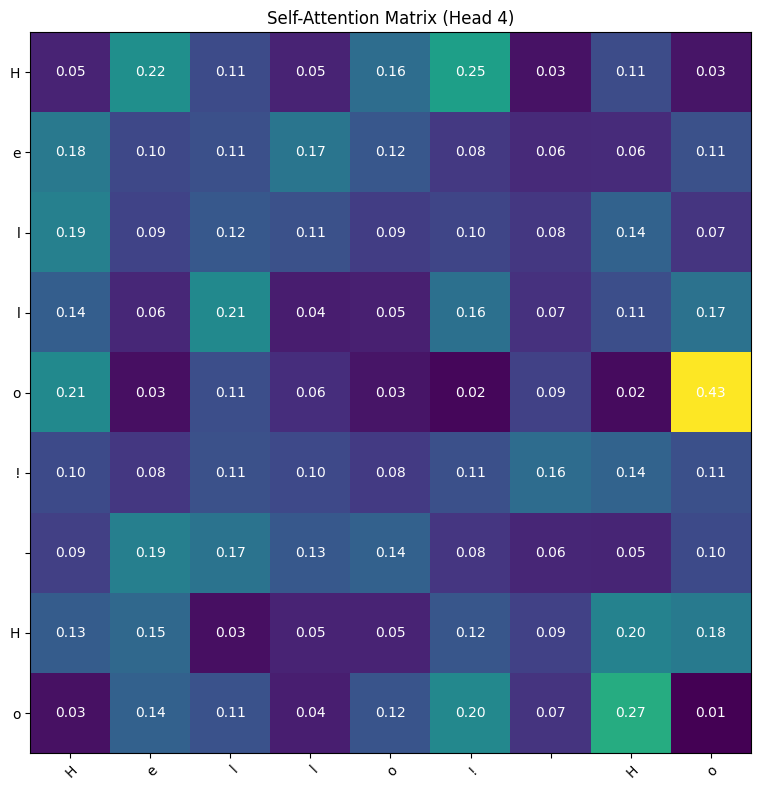

In [45]:
import matplotlib.pyplot as plt
import numpy as np

head_index = 3
attention_matrix = attention_weights.squeeze(0)[head_index].detach().numpy()

matrix_size = attention_matrix.shape[0]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(attention_matrix, cmap='viridis')


ax.set_xticks(np.arange(matrix_size))
ax.set_yticks(np.arange(matrix_size))

ax.set_xticklabels(sentence[:matrix_size])
ax.set_yticklabels(sentence[:matrix_size])


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(matrix_size):
    for j in range(matrix_size):
        text = ax.text(j, i, f"{attention_matrix[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_title(f"Self-Attention Matrix (Head {head_index + 1})")
fig.tight_layout()
plt.show()